# Maxima finding algorithm recreated from implementation in Fiji (ImageJ)

This is a re-implementation of the java plugin written by Michael Schmid and Wayne Rasband for ImageJ. The original java code source can be found in: https://imagej.nih.gov/ij/developer/source/ij/plugin/filter/MaximumFinder.java.html
This code calls a cython compiled version of the code and is much faster than the python only implementation. If compiling the source code is a problem please check the find_maxima.ipynb notebook.

In [6]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys

from findmaxima2d import find_maxima, find_local_maxima #Version that has been installed into python site-packages.

from PIL import Image
import numpy as np

import time

#This is to validate the accuracy compared to the original.
cntly = np.array([  6,  15,  15,  20,  36,  44,  50,  56,  59,  62,  70,  70,  71,
         76,  83,  89,  93,  96, 109, 111, 126, 133, 134, 135, 136, 148,
        149, 158, 162, 162, 163, 164, 164, 164, 168, 169, 171, 182, 183,
        184, 185, 186, 187, 189, 194, 197, 205, 211, 215, 221, 222, 225,
        226, 228, 231, 233, 241, 243, 244, 245, 245, 248, 252, 257, 263,
        265, 271, 275, 278, 278, 287, 290, 296, 298, 301, 309, 318, 323,
        326, 327, 334, 335, 339, 342, 345, 345, 346, 347, 351, 351, 352,
        358, 366, 366, 371, 372, 375, 379, 383, 384, 396, 411, 414, 415,
        418, 418, 420, 431, 439, 439, 443, 455, 461, 467, 468, 469, 471,
        473, 479, 479])
cntlx = np.array([244, 306, 364, 408, 244, 123, 284, 284,  36, 332, 183, 339, 199,
        362, 160, 226, 125, 446, 320, 102, 159,  92, 127,   0,  17, 429,
        141, 169, 127, 261,  56,  51, 113, 130, 437,  80, 149,  34, 359,
         17,  69, 273,  78,  62, 352, 445, 365, 165,  54,  46,  61, 473,
        458,  52,  43, 361,  86, 407,  51,  43,  65, 455, 168, 187, 230,
        159,  51,  67,  71, 321, 107, 257, 399, 405, 402,  77,  77,  54,
        469, 125, 197,  78,  48, 333,  12,  90, 397, 220,  21, 332, 272,
        160, 361, 443, 363, 253, 363,   4, 482, 106, 379, 329, 131, 338,
        131, 491, 215, 130, 334, 358,  55, 429, 106, 229,  92, 100, 376,
        210, 180, 448])

In [7]:
img = Image.open('002eggs.png')
ntol = 10 #Noise Tolerance.
img_data = np.array(img).astype(np.float64)

t1 = time.time()
#Should your image be an RGB image.
if img_data.shape.__len__() >2:
    img_data = (np.sum(img_data,2)/3.0)
    


#Finds the local maxima using mximum filter.
local_max = find_local_maxima(img_data)

y, x, regs = find_maxima(img_data,local_max,ntol)
print(time.time()-t1)
assert(np.allclose(cntly,y)),"Your values don't match the control"
assert(np.allclose(cntlx,x)),"Your values don't match the control"


0.07534098625183105


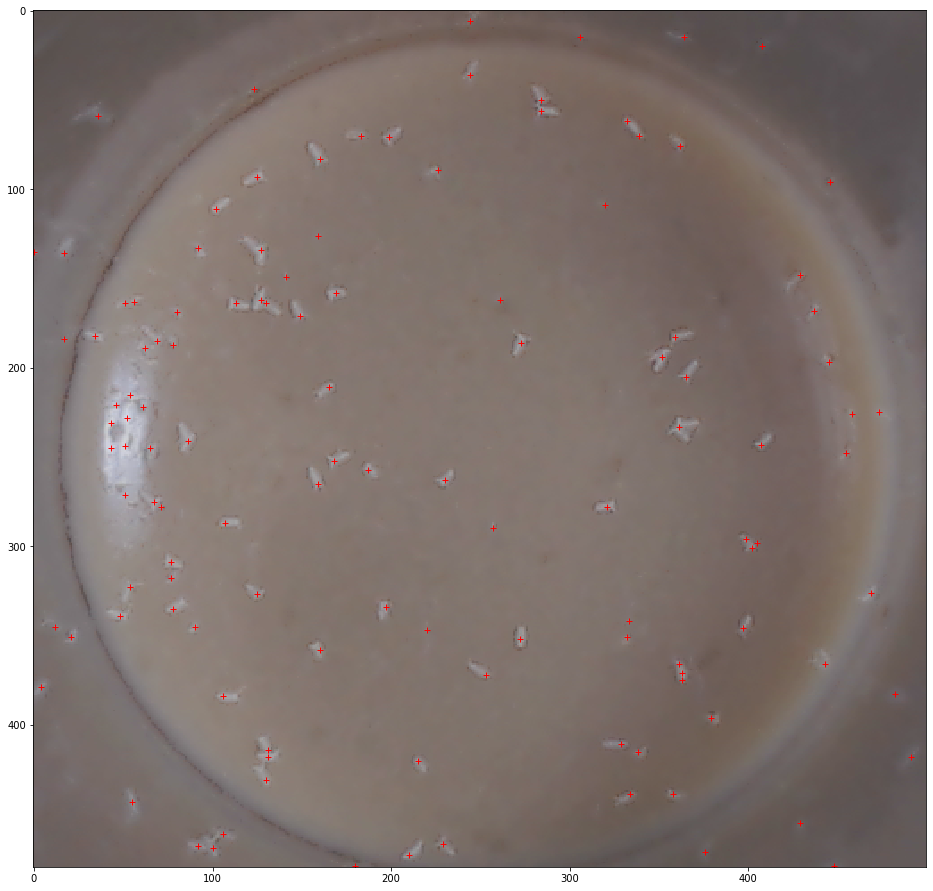

In [12]:
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.plot(x,y,'r+')